## Simple tests for grabbing frames

OpenCV has a nice wrapper around webcams. Let's test it there to get the simplest code that we would need in our library.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
import matplotlib.pyplot as plt
%matplotlib inline
import time
import cv2
cv2.__version__

'3.0.0'

In [3]:
class Source:
    def __init__(self, w=640, h=480):
        self.h, self.w = h, w
        import cv2
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.w)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.h)
      
    def grab(self):
        # grab a frame
        returned, cam_data = self.cap.read()
        data = cam_data.reshape((self.h, self.w, 3))
        return data
    
    def close(self):
        self.cap.release()

start = time.time()
cam = Source()
cam.close()
print('Time to start and stop the camera = ',  time.time() - start , '(s)')


Time to start and stop the camera =  1.7971620559692383 (s)


This is implemented in the ``LeCheapEyeTracker``class:

In [4]:
from LeCheapEyeTracker import LeCheapEyeTracker

cam = LeCheapEyeTracker()
cam.print_info()
cam.close()


APERTURE 0.0
AUTO_EXPOSURE 0.0
BACKLIGHT 0.0
BRIGHTNESS 0.0
CONTRAST 0.0
CONVERT_RGB 0.0
DC1394_MAX 0.0
DC1394_MODE_AUTO 0.0
DC1394_MODE_MANUAL 0.0
DC1394_MODE_ONE_PUSH_AUTO 0.0
DC1394_OFF 0.0
EXPOSURE 0.0
EXPOSUREPROGRAM 0.0
FOCUS 0.0
FORMAT 0.0
FOURCC 0.0
FPS 0.0
FRAME_COUNT 0.0
FRAME_HEIGHT 720.0
FRAME_WIDTH 1280.0
GAIN 0.0
GAMMA 0.0
GUID 0.0
HUE 0.0
IRIS 0.0
ISO_SPEED 0.0
MODE 0.0
PAN 0.0
POS_AVI_RATIO 0.0
POS_FRAMES 0.0
POS_MSEC 0.0
RECTIFICATION 0.0
ROLL 0.0
SATURATION 0.0
SETTINGS 0.0
SHARPNESS 0.0
SPEED 0.0
TEMPERATURE 0.0
TILT 0.0
TRIGGER 0.0
TRIGGER_DELAY 0.0
VIEWFINDER 0.0
WHITE_BALANCE_BLUE_U 0.0
WHITE_BALANCE_RED_V 0.0
ZOOM 0.0


In [5]:
from LeCheapEyeTracker import LeCheapEyeTracker
for DOWNSCALE in [1, 2, 4, 8, 16]:
    start = time.time()
    cam = LeCheapEyeTracker(DOWNSCALE=DOWNSCALE)
    cam.close()
    print('DOWNSCALE = ', DOWNSCALE, 'startup= ',  time.time() - start , '(s)')

DOWNSCALE =  1 startup=  2.2520089149475098 (s)
DOWNSCALE =  2 startup=  2.2288107872009277 (s)
DOWNSCALE =  4 startup=  2.233114004135132 (s)
DOWNSCALE =  8 startup=  2.2489829063415527 (s)
DOWNSCALE =  16 startup=  2.2390849590301514 (s)


Time to start, grab 2 frames and stop =  2.2667579650878906 (s)
(480, 640, 3) 0 216


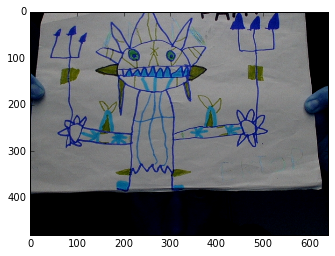

In [6]:
start = time.time()
cam = LeCheapEyeTracker(DOWNSCALE=2)
img = cam.grab()
img = cam.grab()
cam.close()
print('Time to start, grab 2 frames and stop = ',  time.time() - start , '(s)')
print(img.shape, img.min(), img.max())
plt.imshow(img)

In [7]:
from LeCheapEyeTracker import LeCheapEyeTracker
for DOWNSCALE in [1, 2, 4, 8, 16]:
    cam = LeCheapEyeTracker(DOWNSCALE=DOWNSCALE)
    start = time.time()
    img = cam.grab()
    img = cam.grab()
    cam.close()
    print('DOWNSCALE = ', DOWNSCALE, 'grab time= ',  time.time() - start , '(s)')

DOWNSCALE =  1 grab time=  0.05447196960449219 (s)
DOWNSCALE =  2 grab time=  0.052411794662475586 (s)
DOWNSCALE =  4 grab time=  0.050395965576171875 (s)
DOWNSCALE =  8 grab time=  0.058129072189331055 (s)
DOWNSCALE =  16 grab time=  0.05203700065612793 (s)


## how fast do we grab frames?

In [8]:
N = 100
ctime = np.zeros(N)
start = time.time()
cam = LeCheapEyeTracker()
for i in range(N):
    img = cam.grab()
    ctime[i] = time.time() - start
cam.close()

FPS :  30.1475144515


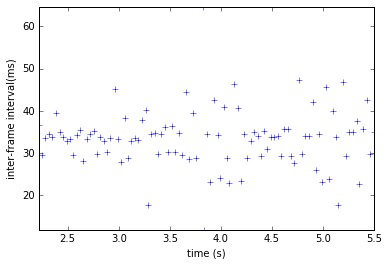

In [9]:
plt.plot(ctime[1:], np.diff(ctime)*1000, '+')
plt.xlabel('time (s)')
plt.ylabel('inter-frame interval(ms)')
_ = plt.axis('tight')
print ('FPS : ',  N/(ctime[-1]-ctime[0]))

## closing the camera

In [10]:
cam.cap.isOpened()

False

In [11]:
cam.cap.release()

## threaded mode

Following the documentation @ http://docs.opencv.org/modules/highgui/doc/reading_and_writing_images_and_video.html?highlight=imread it is easy to run parallel captures :

In [12]:
from multiprocessing.pool import ThreadPool
from collections import deque
import cv2
import time

class StatValue:
    def __init__(self, smooth_coef = 0.5):
        self.value = None
        self.smooth_coef = smooth_coef
    def update(self, v):
        if self.value is None:
            self.value = v
        else:
            c = self.smooth_coef
            self.value = c * self.value + (1.0-c) * v

def clock():
    return cv2.getTickCount() / cv2.getTickFrequency()

def draw_str(dst, target, s):
    x, y = target
    cv2.putText(dst, s, (x+1, y+1), cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness = 2, lineType=cv2.LINE_AA)
    cv2.putText(dst, s, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv2.LINE_AA)


class ThreadSource:
    def __init__(self, w=640, h=480, threads=True):
        self.h, self.w = h, w
        import cv2
        self.cap = cv2.VideoCapture(0)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.w)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.h)

        if threads:
            self.threadn = cv2.getNumberOfCPUs()
        else:
            self.threadn = 1
        self.pool = ThreadPool(processes = self.threadn)
        self.pending = deque()

        self.latency = StatValue()
        self.frame_interval = StatValue()
        self.last_frame_time = clock()        
        self.display = False
        self.ctime = []
        self.N = 0

    def process_frame(self, frame, t0):
        # some intensive computation...
        frame = cv2.medianBlur(frame, 19)
        time.sleep(.1)
        frame = cv2.medianBlur(frame, 19)
        return frame, t0

    def run(self, T=10):
        start = clock()
        while clock()-start <10.:
            while len(self.pending) > 0 and self.pending[0].ready():
                res, t0 = self.pending.popleft().get()
                self.latency.update(clock() - t0)
                if self.display:
                    draw_str(res, (20, 40), "latency        :  %.1f ms" % (self.latency.value*1000))
                    draw_str(res, (20, 60), "frame interval :  %.1f ms" % (self.frame_interval.value*1000))
                    cv2.imshow('Webcam video', res)
                self.ctime.append(time.time() - start)
                self.N += 1
            if len(self.pending) < self.threadn:
                ret, frame = self.cap.read()
                t = clock()
                self.frame_interval.update(t - self.last_frame_time)
                self.last_frame_time = t
                task = self.pool.apply_async(self.process_frame, (frame.copy(), t))
                self.pending.append(task)
            ch = 0xFF & cv2.waitKey(1)
            if ch == 27:
                self.close()
    
    def close(self):
        self.cap.release()
        if self.display: cv2.destroyAllWindows()

start = time.time()
cam = ThreadSource()
ctime = cam.run()
cam.close()
start_nothreads = time.time()
cam_nothreads = ThreadSource(threads=False)
ctime = cam_nothreads.run()
cam_nothreads.close()

FPS threaded:  17.800840873374025
FPS one thread:  5.415146539543378


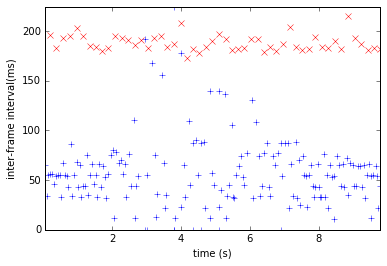

In [13]:
plt.plot(np.array(cam.ctime)[1:]-cam.ctime[0], np.diff(np.array(cam.ctime))*1000, 'b+')
plt.plot(np.array(cam_nothreads.ctime)[1:]-cam_nothreads.ctime[0], np.diff(np.array(cam_nothreads.ctime))*1000, 'rx')
plt.xlabel('time (s)')
plt.ylabel('inter-frame interval(ms)')
_ = plt.axis('tight')
print ('FPS threaded: ',  cam.N/(cam.ctime[-1]-cam.ctime[0]))
print ('FPS one thread: ',  cam_nothreads.N/(cam_nothreads.ctime[-1]-cam_nothreads.ctime[0]))

In practice, we will see nice improvments when the image processing pipeline is more consequent. This threaded mode is enabled by default.

##  creating a video for debugging

It may be sometimes useful to just read out some frames for debugging.

In [14]:
import os
N_frame = 512 # how much you want?
folder = '/tmp/debug' # where we do save the frames
try: 
    os.mkdir(folder)
except: pass

from LeCheapEyeTracker import LeCheapEyeTracker
cam = LeCheapEyeTracker()
start = cam.clock()
for i in range(N_frame):
    ret, frame = cam.cap.read()
    t = cam.clock() - start   
    # https://docs.python.org/3.3/library/string.html#format-examples
    timestr = '{t:03.5f}'.format(t=t).replace('.', '_')
    fname = 'frame_{i}_at_{t}.png'.format(i=i, t=timestr)
    print(fname)
    cv2.imwrite(os.path.join(folder, fname), frame)

cam.close()

frame_0_at_0_00322.png
frame_1_at_0_04209.png
frame_2_at_0_09589.png
frame_3_at_0_15138.png
frame_4_at_0_20259.png
frame_5_at_0_27510.png
frame_6_at_0_32329.png
frame_7_at_0_41684.png
frame_8_at_0_47508.png
frame_9_at_0_52500.png
frame_10_at_0_57794.png
frame_11_at_0_64054.png
frame_12_at_0_69445.png
frame_13_at_0_75135.png
frame_14_at_0_80679.png
frame_15_at_0_86620.png
frame_16_at_0_92503.png
frame_17_at_0_97704.png
frame_18_at_1_03227.png
frame_19_at_1_08743.png
frame_20_at_1_13623.png
frame_21_at_1_19137.png
frame_22_at_1_24986.png
frame_23_at_1_31113.png
frame_24_at_1_37448.png
frame_25_at_1_43252.png
frame_26_at_1_49577.png
frame_27_at_1_54828.png
frame_28_at_1_60924.png
frame_29_at_1_66449.png
frame_30_at_1_71284.png
frame_31_at_1_75695.png
frame_32_at_1_80659.png
frame_33_at_1_85521.png
frame_34_at_1_92909.png
frame_35_at_1_99768.png
frame_36_at_2_04694.png
frame_37_at_2_09766.png
frame_38_at_2_16194.png
frame_39_at_2_22628.png
frame_40_at_2_32233.png
frame_41_at_2_38669.png
fr